# Logistic Regression

This notebook covers a Python-based solution for the second programming exercise of the machine learning course on Coursera.

In this exercise we'll implement logistic regression and apply it to a classification task.

The first part of this exercise, we'll build a logistic regression model to predict whether a student gets admitted to a university. Suppose you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision. To accomplish this, we're going to build a classification model that estimates the probability of admission based on the exam scores.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
path = os.getcwd() + '/data/logistic_regression1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Creating a scatter plot of the two scores and using color coding to visualise of the example is admitted or not

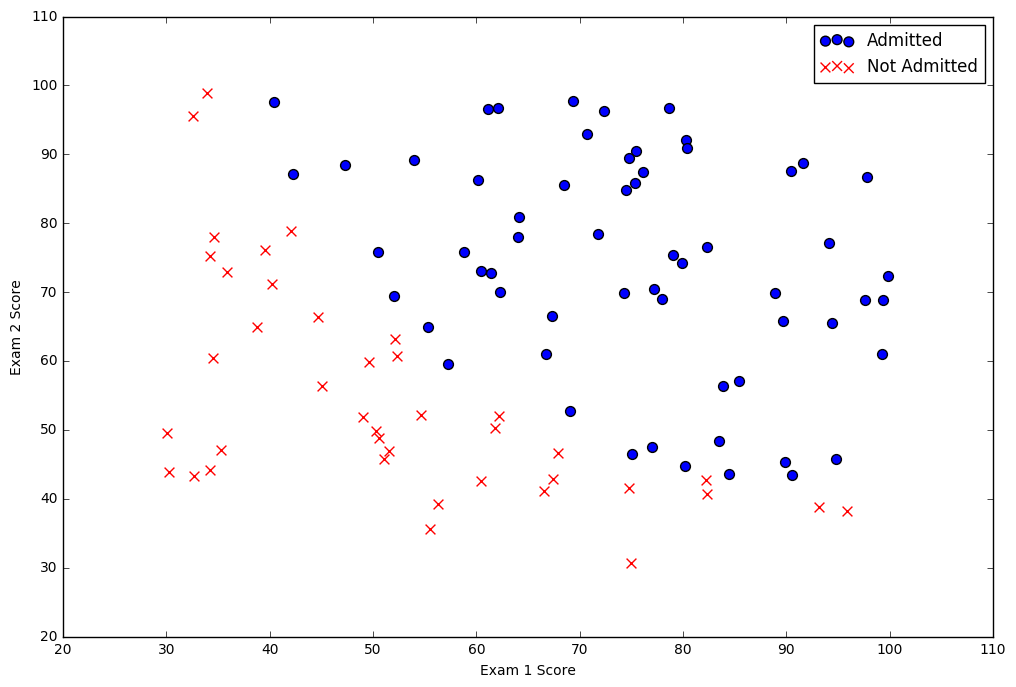

In [4]:
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

There is a clear decision boundary between the two classes. Now we just need to implement logisitic regression in order to train a model predict the outcome.

First we need to create a sigmoid function

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Sanity checks to make sure the function is working

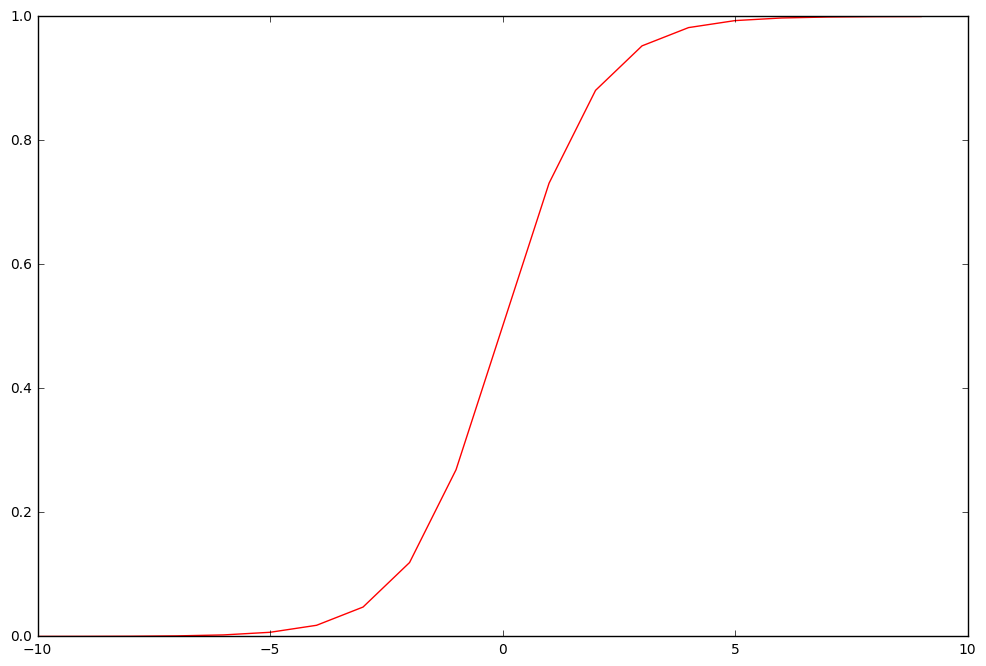

In [6]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, sigmoid(nums), 'r')

Now we need to write a cost function to evaluate the solution.

In [7]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    return np.sum(first - second) / (len(X))

Now we need to do some setup

In [8]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# convert to numpy arrays and initialise the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(3)

Quick check of the shape of the arrays to make sure every thing looks good

In [9]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

Let's compute the cost for our initial solution (0 values for theta)

In [10]:
cost(theta, X, y)

0.69314718055994529

Great. Next we need a function to compute the gradient (parameter updates) given our training data, labels, and some parameters theta.

In [11]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
        
    return grad

Note that we don't actually perform gradient descent in this function - we just compute a single gradient step. In the exercise, an Octave function called "fminunc" is used to optimize the parameters given functions to compute the cost and the gradients. Since we're using Python, we can use SciPy's "optimize" namespace to do the same thing.

let's look at a single call to the gradient method using our data and initial paramter values of 0.

In [12]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

Now we can use SciPy's truncated newton (TNC) implementation to find the optimal parameters

In [13]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X,y))
result

(array([-25.87368015,   0.21193784,   0.20722683]), 51, 1)

Let's see what the cost looks like with this solution

In [14]:
cost(result[0], X, y)

0.20357136945721863

Next we need to write a function that will output predictions for a dataset X using our learned parameters theta. We can then use this function to score the training accuracy of our classifier.

In [15]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [16]:
theta_min = np.matrix(result[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print 'accuracy = {0}%'.format(accuracy)

accuracy = 89%


Our logistic regression classifer correctly predicted if a student was admitted or not 89% of the time. We didn't keep a hold-out set or use cross-validation to get a true approximation of the accuracy so this number is likely higher than its true perfomance.

## Regularized Logistic Regression


In the second part of this exercise, we'll improve our logistic regression algorithm from part one by adding a regularization term. In a nutshell, regularization is a term in the cost function that causes the algorithm to prefer "simpler" models (in this case, models will smaller coefficients). The theory is that this helps to minimize overfitting and improve the model's ability to generalize.


Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

Start by visualizing the data

In [17]:
path = os.getcwd() + '/data/logistic_regression2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


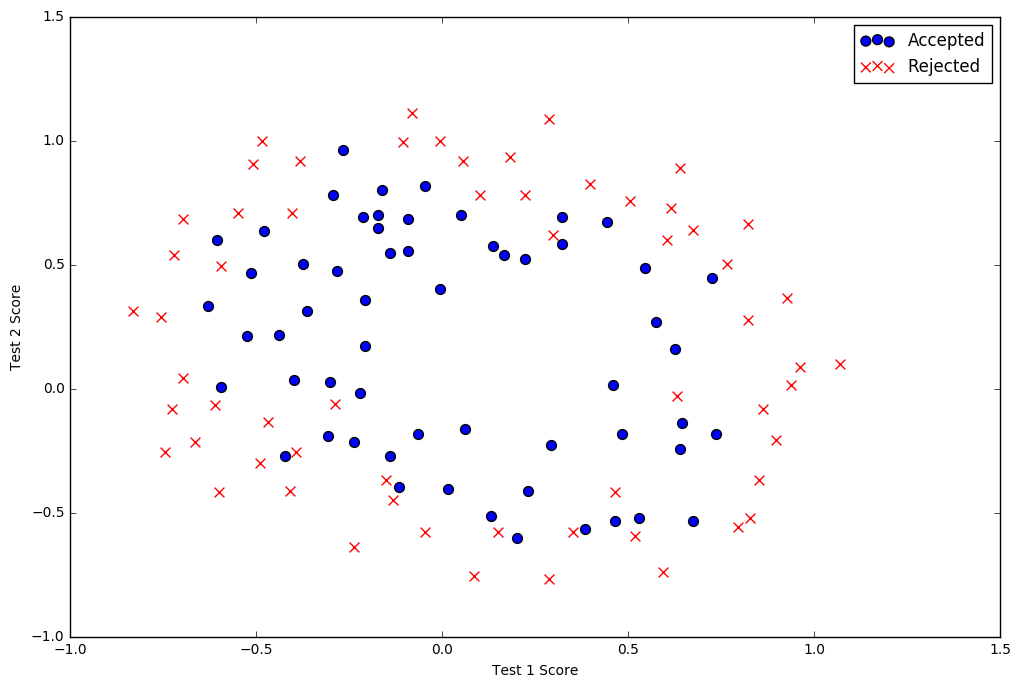

In [18]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

This data looks a bit more complicated than the previous example. In particular, there is no linear decision boundary that will perform well on this data. One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features. Let's start by creating a bunch of polynomial features.

In [19]:
degree = 5
x1 = data2['Test 1']
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)

for i in range(1, degree):
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)
        
data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

,Accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


Now modify the cost and gradient function form part 1 to include the regularization term.

In [20]:
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

Note the addition of a "learning rate" parameter. This is a hyperparameter that controls the effectiveness of the regularization term. Now we need to add regularization to the gradient function:

In [21]:
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

Initialise variables

In [22]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(11)

Initialise the learning rate

In [23]:
learningRate = 1

Now let's try calling our new regularized functions with the default (0) values for theta to make sure the calculations are working.

In [24]:
costReg(theta2, X2, y2, learningRate)

0.6931471805599454

In [25]:
gradientReg(theta2, X2, y2, learningRate)

array([ 0.00847458,  0.01878809,  0.05034464,  0.01150133,  0.01835599,
        0.00732393,  0.00819244,  0.03934862,  0.00223924,  0.01286005,
        0.00309594])

Now use the same optimisation function as before to compute the optimal solution

In [26]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
result2

(array([  0.35868003,  -3.22216355,  18.97111499,  -4.25279531,
         18.23060947,  20.36463078,   8.94235258, -43.77493272,
        -17.93536391, -50.75138715,  -2.84266952]), 110, 1)

Finally use the prediction function to see how accurate our solution is on the training data

In [27]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))
print 'accuracy = {0}%'.format(accuracy)

accuracy = 91%


## Using Scikit-learn

In [30]:
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X2, y2.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
model.score(X2, y2)

0.66101694915254239

The accuracy is